In [11]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

from shapely.geometry import Polygon, MultiPolygon

# few less-common pip packages
import alphashape
import tripy


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "..\\comm_channel")
sys.path.insert(0, "..\\polling_systems")

#So we can import my local libs
import CommChannel as CC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr


def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.where(r>0)
    pts = np.array(idcs).T - [region[1], region[3]]
    pts = pts/res
    return pts, np.array(idcs).T

In [2]:
#Setup the system:

#For now, use same channel params
nPL = 4.2  
kPL = -40

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();#cc.generateMP(2)

Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.


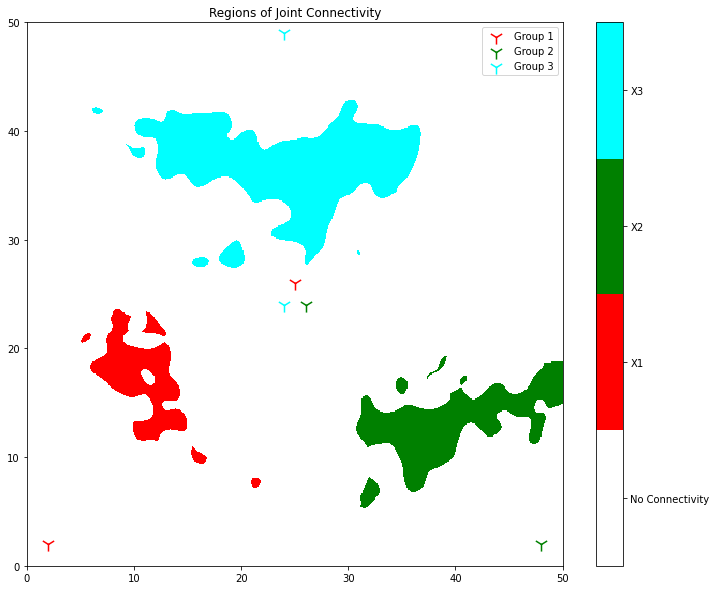

In [3]:
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [4]:
pts1, idcs1 = indices_to_pts(r1, region, res)
pts2, idcs2 = indices_to_pts(r2, region, res)
pts3, idcs3 = indices_to_pts(r3, region, res)

all_pts, _ = indices_to_pts(np.ones(r1.shape), region, res)

els = [0.5, 0.7, 0.5]
beta = 0.2
dt_sys = dtr.DTR(ccs, els, beta)

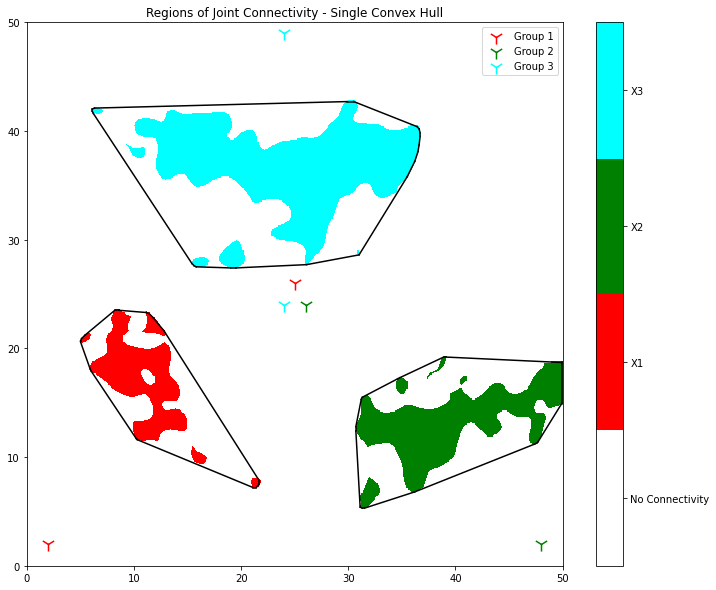

In [5]:
#SINGLE CONVEX HULL
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - Single Convex Hull', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    hull = ConvexHull(points)
    #plt.plot(points[:,0], points[:,1], 'o')

    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

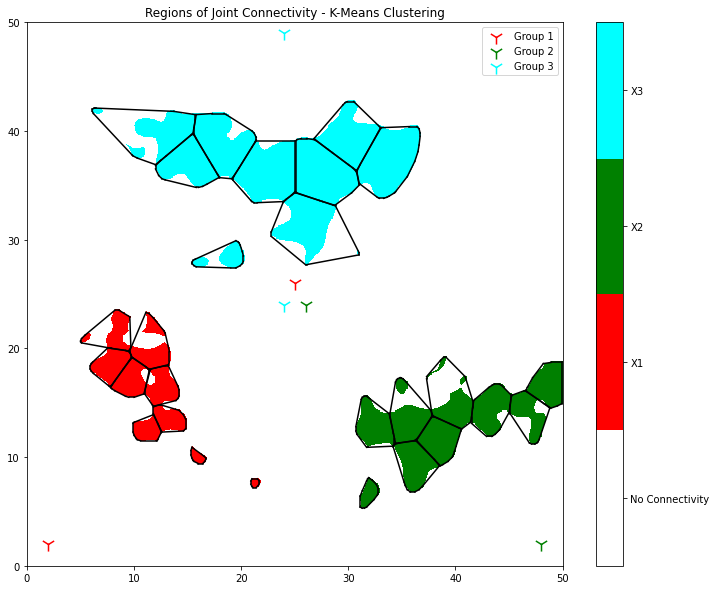

In [6]:
#Kmeans with large k
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']

    k=9
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1).fit(points)
    kml = kmeans.labels_
    idcs = [np.where(kml == c) for c in range(k)]

    for i in range(k):
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        #plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-', )
            
plt.show()

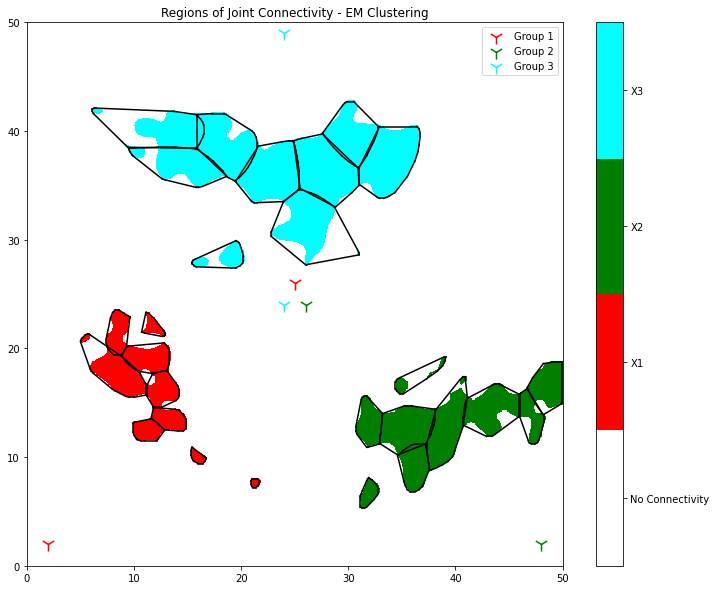

In [7]:
#EM
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - EM Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for j in range(3):
    points = dt_sys.Xis[j]['points']

    min_bic = np.Inf
    n_comp = -1
    best_labels = None
    for k in range(2,10):
        gmm = GaussianMixture(n_components = k, n_init=10)
        labels = gmm.fit_predict(points)
        bic = gmm.bic(points)
        if bic < min_bic:
            min_bic = bic
            n_comp = k
            best_labels = labels


    idcs = [np.where(best_labels == c) for c in range(n_comp)]


    for i in range(n_comp):
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        #plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')

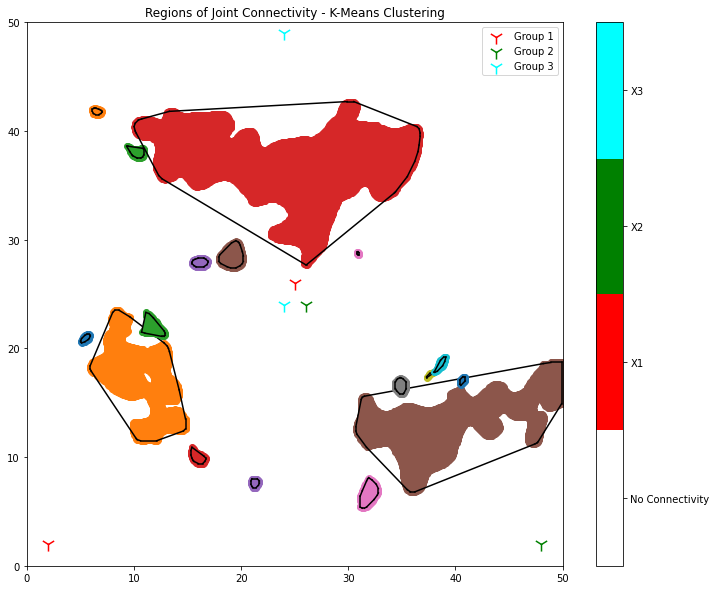

In [8]:
#with DBSCAN
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    clustering = DBSCAN(eps=(1.5)/res, min_samples=5).fit(points)
    labels = clustering.labels_
    c_count = len(set(labels))
    idcs = [np.where(labels == c) for c in range(c_count)]


    for i in range(c_count):
        if len(idcs[i][0]) == 0:
            continue
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')
            
plt.show()

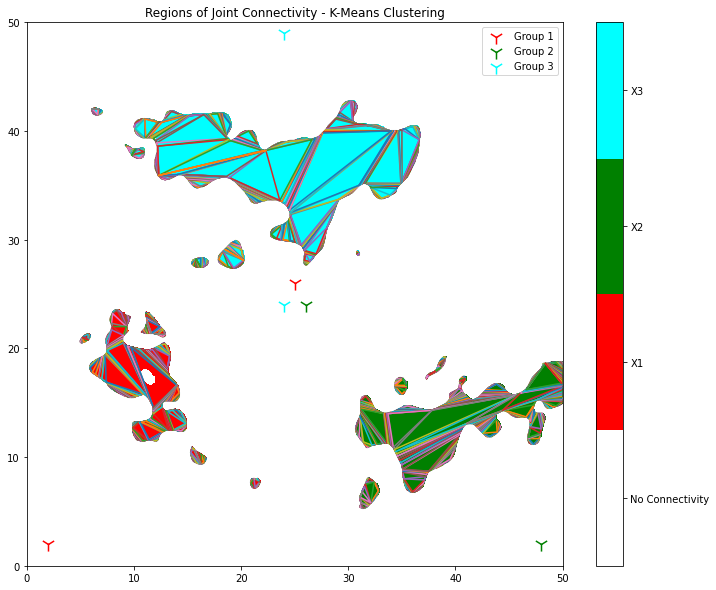

In [13]:
#With Alphashape
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    shapes = alphashape.alphashape(points, 4)
    #plot the shape(s)
    if isinstance(shapes, MultiPolygon):
        for shape in shapes:
            #get vertices
            x,y = shape.exterior.coords.xy
            plt.plot(x,y, 'k-')
            vertices = [(x[i], y[i]) for i in range(len(x))]
            triangulation = tripy.earclip(vertices)
            for triangle in triangulation:
                t_np = np.array(triangle)
                plt.plot(t_np[:,0], t_np[:,1])
    elif isinstance(shapes, Polygon):
        x,y = shapes.exterior.coords.xy
        plt.plot(x,y, 'k-')
    else:
        print('Non-polygonal shape found: %s'%type(shapes))
    
plt.show()